# Time series forecasting


## Data processing

In [357]:
# Import 

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [358]:
start_date = "2010-01-01"
end_date = "2024-12-31"

# Dataset
df = yf.download("AAPL", start=start_date, end=end_date)

# Cette commande garde le niveau 0 ('Close', 'High'...) et jette le niveau 1 ('AAPL')
df.columns = df.columns.droplevel(1)

# Vérification : Affiche les nouvelles colonnes
print(df.columns)

# Features
df["return"] = df["Close"].pct_change()
df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
df["log_volume"] = np.log(1 + df["Volume"])
df["high-low"] = df["High"] - df["Low"]

df = df.dropna()


/var/folders/vp/6wb8xsys5v93hnh1zt4zdj5w0000gn/T/ipykernel_20037/2813678749.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


In [359]:
df.head()

Price,Close,High,Low,Open,Volume,return,log_return,log_volume,high-low
Date,,,,,,,,,
2010-01-05,6.429480,6.465769,6.395590,6.436078,601904800,0.001729,0.001728,20.215610,0.070179
2010-01-06,6.327210,6.454972,6.320612,6.429480,552160000,-0.015906,-0.016034,20.129348,0.134360
2010-01-07,6.315515,6.358102,6.269628,6.350604,477131200,-0.001849,-0.001850,19.983302,0.088474
2010-01-08,6.357502,6.358102,6.269929,6.307117,447610800,0.006648,0.006626,19.919435,0.088173
2010-01-11,6.301419,6.388092,6.251633,6.382094,462229600,-0.008822,-0.008861,19.951572,0.136459


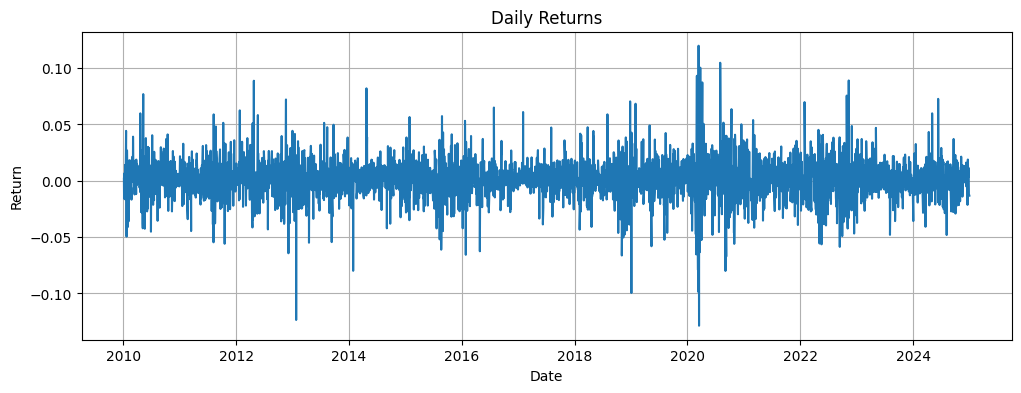

In [360]:
plt.figure(figsize=(12,4))
plt.plot(df["return"])
plt.title("Daily Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.grid(True)
plt.show()


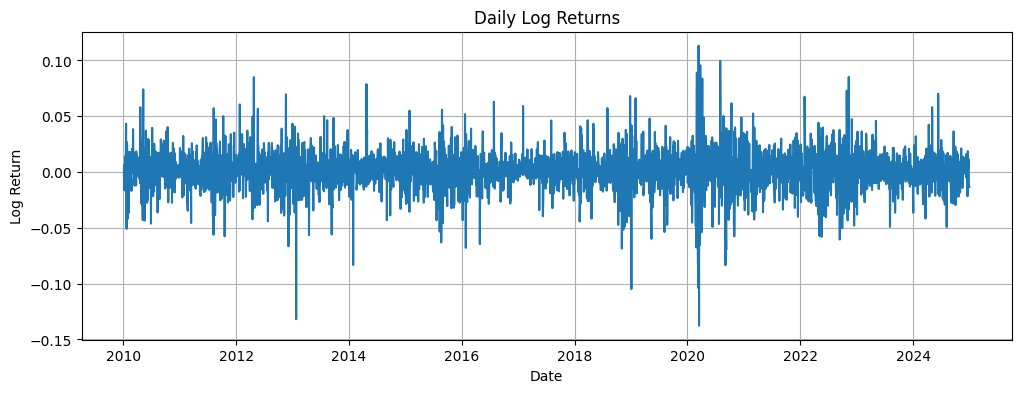

In [361]:
plt.figure(figsize=(12,4))
plt.plot(df["log_return"])
plt.title("Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.show()

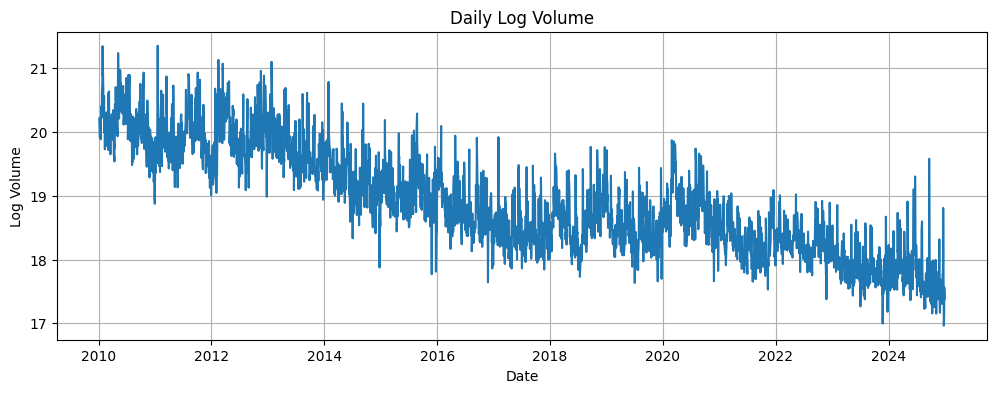

In [362]:
plt.figure(figsize=(12,4))
plt.plot(df["log_volume"])
plt.title("Daily Log Volume")
plt.xlabel("Date")
plt.ylabel("Log Volume")
plt.grid(True)
plt.show()

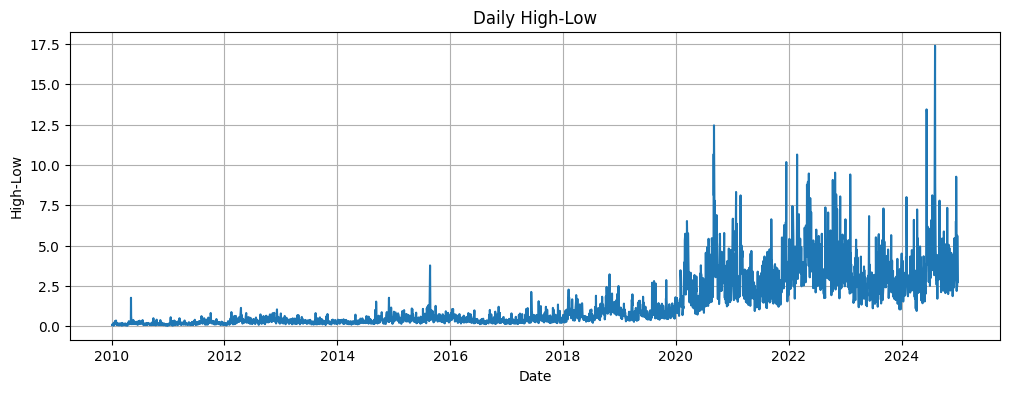

In [363]:
plt.figure(figsize=(12,4))
plt.plot(df["high-low"])
plt.title("Daily High-Low")
plt.xlabel("Date")
plt.ylabel("High-Low")
plt.grid(True)
plt.show()

## AR(1)

In [364]:
data = df["log_return"].values
n_test = 100  # Les 100 derniers points
train_data = [x for x in data[:-n_test]]
test_data = data[-n_test:]
pred_ar1 = []


for i in range(len(test_data)):
    model = AutoReg(train_data, lags=1).fit()
    
    pred_one_step = model.forecast(steps=1)[0]
    pred_ar1.append(pred_one_step)
    
    real_observation = test_data[i]
    train_data.append(real_observation)

mse = mean_squared_error(test_data, pred_ar1)
rmse = np.sqrt(mse)
print(f"RMSE Walk-Forward : {rmse:.5f}")



RMSE Walk-Forward : 0.01158


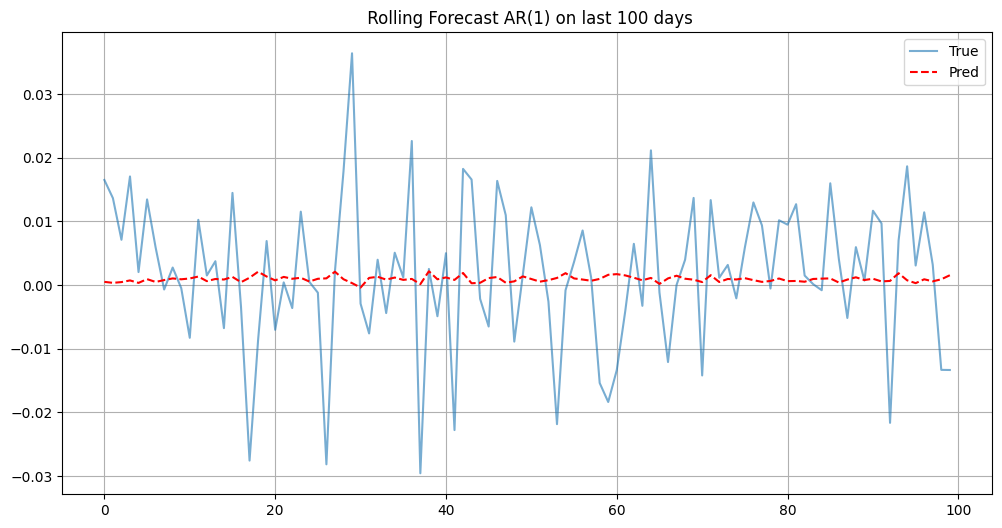

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 3771
Model:                     AutoReg(1)   Log Likelihood                9891.997
Method:               Conditional MLE   S.D. of innovations              0.018
Date:                Tue, 06 Jan 2026   AIC                         -19777.995
Time:                        17:51:53   BIC                         -19759.290
Sample:                             1   HQIC                        -19771.345
                                 3771                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      3.541      0.000       0.000       0.002
y.L1          -0.0388      0.016     -2.384      0.017      -0.071      -0.007
                                    Roots           

In [365]:
plt.figure(figsize=(12, 6))

plt.plot(range(n_test), test_data, label="True", alpha=0.6)
plt.plot(range(n_test), pred_ar1, label="Pred", color='red', linestyle='--')
plt.title(f" Rolling Forecast AR(1) on last {n_test} days")
plt.legend()
plt.grid(True)
plt.show()

print(model.summary())

In [366]:
y_true = np.array(test_data)
y_pred_ar1 = np.array(pred_ar1)

correct_direction = np.sign(y_true) == np.sign(y_pred_ar1)

hit_ratio = np.mean(correct_direction) * 100

print(f"Précision directionnelle (Hit Ratio) : {hit_ratio:.2f}%")

Précision directionnelle (Hit Ratio) : 62.00%


## ARIMA(1,0,1)

In [367]:
pred_arima = []

for t in range(len(test_data)):
    model = ARIMA(train_data, order=(1, 0, 1))
    model_fit = model.fit()

    output = model_fit.forecast()
    yhat = output[0]
    pred_arima.append(yhat)
    
    obs = test_data[t]
    train_data.append(obs)

mse = mean_squared_error(test_data, pred_arima)
rmse = np.sqrt(mse)
print(f'RMSE ARIMA: {rmse:.5f}')



/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M

RMSE ARIMA: 0.01156


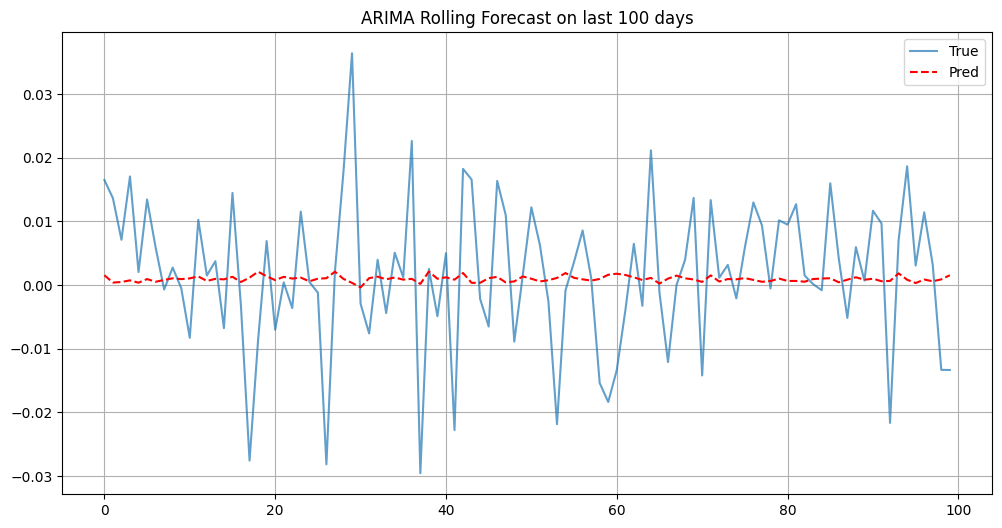

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3871
Model:                 ARIMA(1, 0, 1)   Log Likelihood               10186.073
Date:                Tue, 06 Jan 2026   AIC                         -20364.147
Time:                        17:52:20   BIC                         -20339.102
Sample:                             0   HQIC                        -20355.254
                               - 3871                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      3.559      0.000       0.000       0.002
ar.L1          0.0545      0.283      0.193      0.847      -0.499       0.608
ma.L1         -0.0928      0.284     -0.326      0.7

In [368]:
plt.figure(figsize=(12, 6))
plt.plot(test_data, label='True', alpha=0.7)
plt.plot(pred_arima, color='red', linestyle='--', label='Pred')
plt.title('ARIMA Rolling Forecast on last {} days'.format(n_test))
plt.legend()
plt.grid(True)
plt.show()

print(model_fit.summary())

## LSTM

In [369]:
data = data.reshape(-1, 1)

# Normalisation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Rolling window
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60 
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Train/Test Split
split = len(X) - 100
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential()

# Couche LSTM
model.add(LSTM(units=50, return_sequences=False, input_shape=(SEQ_LENGTH, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compilation
model.compile(optimizer='adam', loss='mean_squared_error')

# Training
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Prediction
predictions_scaled = model.predict(X_test)

predictions = scaler.inverse_transform(predictions_scaled)
y_test_real = scaler.inverse_transform(y_test)

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0775 - val_loss: 0.0024
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0076 - val_loss: 0.0026
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0073 - val_loss: 0.0023
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0069 - val_loss: 0.0025
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0072 - val_loss: 0.0023
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0063 - val_loss: 0.0024
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0068 - val_loss: 0.0028
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0067 - val_loss: 0.0022
Epoch 9/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0064 - val_loss: 0.0023
Epoch 10/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0065 - val_loss: 0.0023
Epoch 11/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0063 - val_loss: 0.0023
Epoch 12/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0

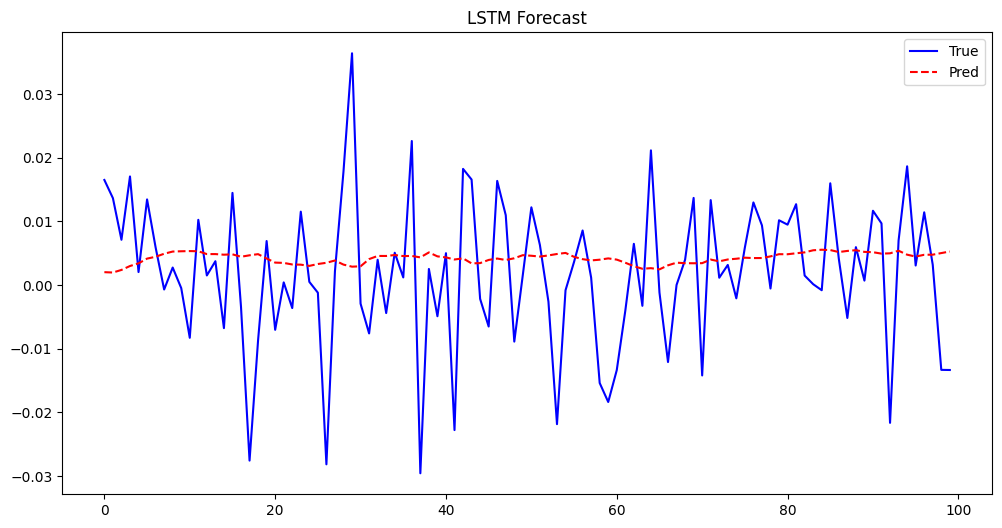

In [370]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label='True', color='blue')
plt.plot(predictions, label='Pred', color='red', linestyle='--')
plt.title('LSTM Forecast')
plt.legend()
plt.show()

In [371]:
features = ['log_return', 'high-low', 'log_volume']
data = df[features].dropna().values  # Shape: (N, 3)

# Normalisation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Rolling window
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length]) 
        y.append(data[i+seq_length, 0]) 
    return np.array(X), np.array(y)

SEQ_LENGTH = 60 
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Train/Test Split
split = len(X) - 100
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Couche LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(SEQ_LENGTH, 3)))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Training
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Prediction
predictions_scaled = model.predict(X_test)

dummy_pred = np.zeros((len(predictions_scaled), 3))
dummy_pred[:, 0] = predictions_scaled.flatten()
predictions = scaler.inverse_transform(dummy_pred)[:, 0]

dummy_y = np.zeros((len(y_test), 3))
dummy_y[:, 0] = y_test
y_test_real = scaler.inverse_transform(dummy_y)[:, 0]



Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0588 - val_loss: 0.0024
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0088 - val_loss: 0.0025
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0076 - val_loss: 0.0022
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - val_loss: 0.0024
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0070 - val_loss: 0.0022
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0066 - val_loss: 0.0027
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0071 - val_loss: 0.0022
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0061 - val_loss: 0.0025
Epoch 9/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0067 - val_loss: 0.0026
Epoch 10/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0066 - val_loss: 0.0022
Epoch 11/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0063 - val_loss: 0.0022
Epoch 12/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.

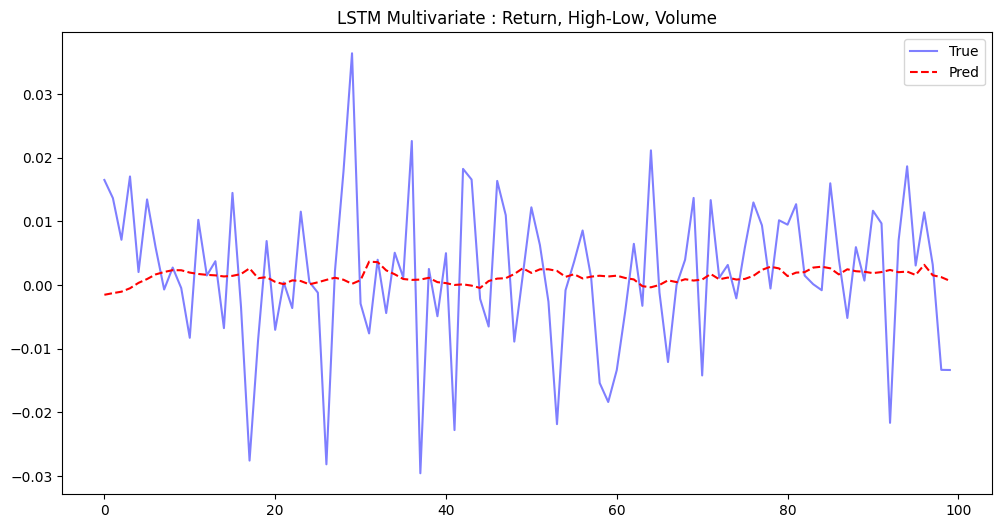

In [372]:
plt.figure(figsize=(12, 6))

plt.plot(y_test_real, label='True', color='blue', alpha=0.5)
plt.plot(predictions, label='Pred', color='red', linestyle='--')
plt.title('LSTM Multivariate : Return, High-Low, Volume')
plt.legend()
plt.show()

Entraînement sur 3423 jours, Test sur 300 jours.
Nombre de features : 13

Accuracy : 51.00%
------------------------------
Matrice de Confusion :
[[62 68]
 [79 91]]
------------------------------
              precision    recall  f1-score   support

           0       0.44      0.48      0.46       130
           1       0.57      0.54      0.55       170

    accuracy                           0.51       300
   macro avg       0.51      0.51      0.51       300
weighted avg       0.51      0.51      0.51       300



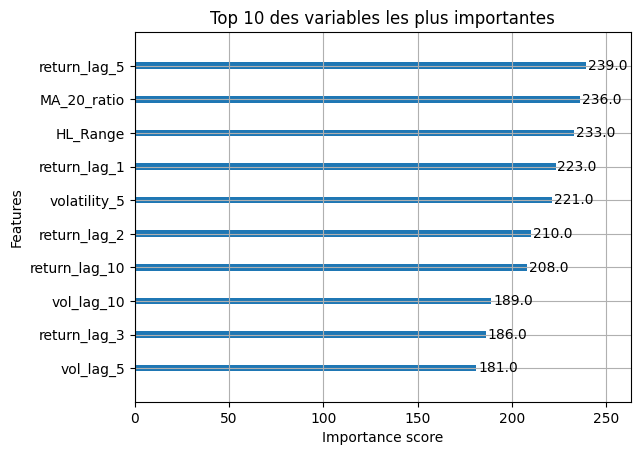

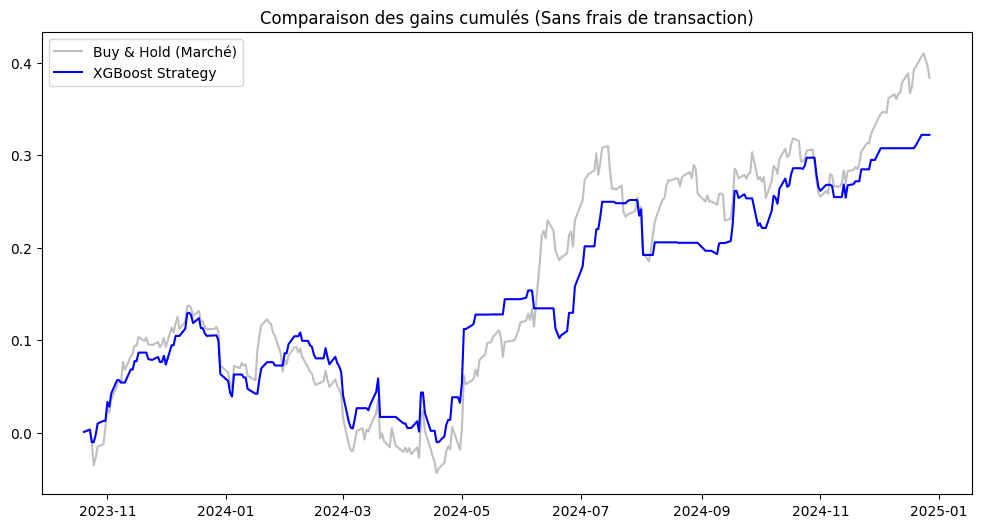

In [375]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# --- 1. Préparation des Features (Aplatir le temps) ---
# On part de ton df qui a maintenant des colonnes simples (Close, High, etc.)

df_xgb = df.copy()

# A. Indicateurs de base
# Volatilité sur 5 jours
df_xgb['volatility_5'] = df_xgb['log_return'].rolling(5).std()
# Moyenne Mobile relative (Prix / Moyenne 20 jours)
df_xgb['MA_20_ratio'] = df_xgb['Close'] / df_xgb['Close'].rolling(20).mean()
# Le High-Low normalisé par le Close
df_xgb['HL_Range'] = (df_xgb['High'] - df_xgb['Low']) / df_xgb['Close']

# B. Création des LAGS (C'est ainsi que XGBoost voit le passé)
# On donne les retours des jours J-1, J-2, J-3, J-5
lags = [1, 2, 3, 5, 10]
for lag in lags:
    df_xgb[f'return_lag_{lag}'] = df_xgb['log_return'].shift(lag)
    df_xgb[f'vol_lag_{lag}'] = df_xgb['log_volume'].shift(lag)

# C. Création de la Cible (Target)
# 1 si le log_return de DEMAIN est positif, sinon 0
df_xgb['Target'] = (df_xgb['log_return'].shift(-1) > 0).astype(int)

# D. Nettoyage
df_xgb = df_xgb.dropna()

# --- 2. Train / Test Split (Chronologique !) ---
# XGBoost n'a pas besoin de MinMaxScaler, on peut laisser les valeurs brutes.

# Sélection des colonnes (Tout sauf la Target et les prix bruts inutiles comme Open/Close absolus)
features = [col for col in df_xgb.columns if 'lag' in col or 'volatility' in col or 'ratio' in col or 'Range' in col]
X = df_xgb[features]
y = df_xgb['Target']

# On coupe les 300 derniers jours pour le test
test_size = 300
X_train = X.iloc[:-test_size]
X_test = X.iloc[-test_size:]
y_train = y.iloc[:-test_size]
y_test = y.iloc[-test_size:]

print(f"Entraînement sur {len(X_train)} jours, Test sur {len(X_test)} jours.")
print(f"Nombre de features : {X.shape[1]}")

# --- 3. Modèle XGBoost ---
# Configuration pour éviter l'overfitting (très important en finance)
model = xgb.XGBClassifier(
    n_estimators=200,       # Nombre d'arbres
    learning_rate=0.05,     # Vitesse d'apprentissage (plus petit = plus robuste)
    max_depth=4,            # Profondeur des arbres (3-5 est bien pour éviter le par coeur)
    subsample=0.8,          # Utilise 80% des données par arbre
    colsample_bytree=0.8,   # Utilise 80% des features par arbre
    random_state=42,
    n_jobs=-1               # Utilise tous les coeurs du CPU
)

# Entraînement
model.fit(X_train, y_train)

# --- 4. Évaluation ---
preds = model.predict(X_test)
proba = model.predict_proba(X_test)[:, 1] # La probabilité que ce soit 1 (Hausse)

acc = accuracy_score(y_test, preds)
print(f"\nAccuracy : {acc*100:.2f}%")
print("-" * 30)
print("Matrice de Confusion :")
print(confusion_matrix(y_test, preds))
print("-" * 30)
print(classification_report(y_test, preds))

# --- 5. Feature Importance (Le super-pouvoir de XGBoost) ---
# Qu'est-ce qui a vraiment compté pour la prédiction ?
xgb.plot_importance(model, max_num_features=10, importance_type='weight')
plt.title("Top 10 des variables les plus importantes")
plt.show()

# --- 6. Backtest Simplifié (Equity Curve) ---
# Si on achète quand le modèle dit "1" et qu'on reste Cash quand il dit "0"
df_test = df_xgb.iloc[-test_size:].copy()
df_test['Prediction'] = preds
df_test['Strategy_Return'] = df_test['Prediction'] * df_test['log_return'].shift(-1) # Le return réel du lendemain

# Cumul
df_test['Cumul_Market'] = df_test['log_return'].shift(-1).cumsum()
df_test['Cumul_Strategy'] = df_test['Strategy_Return'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(df_test['Cumul_Market'], label='Buy & Hold (Marché)', color='gray', alpha=0.5)
plt.plot(df_test['Cumul_Strategy'], label='XGBoost Strategy', color='blue')
plt.title("Comparaison des gains cumulés (Sans frais de transaction)")
plt.legend()
plt.show()

Accuracy améliorée : 52.00%
              precision    recall  f1-score   support

           0       0.42      0.27      0.33       130
           1       0.56      0.71      0.63       170

    accuracy                           0.52       300
   macro avg       0.49      0.49      0.48       300
weighted avg       0.50      0.52      0.50       300

Accuracy sur haute confiance (47 trades) : 57.45%


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

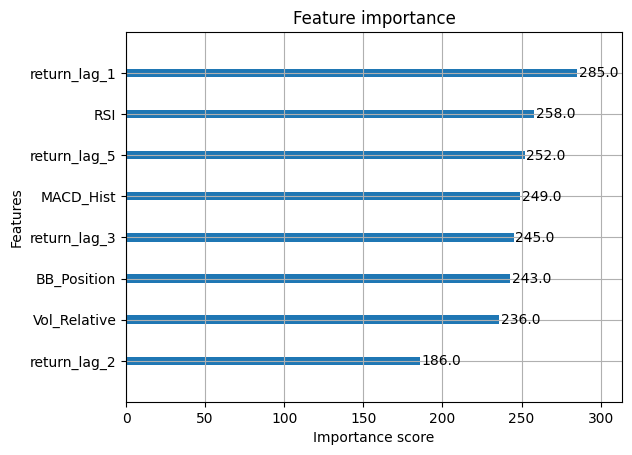

In [376]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# On repart de ton df propre
df_feat = df.copy()

# --- 1. INDICATEURS TECHNIQUES (Calcul Manuel Vectorisé) ---

# A. RSI (Relative Strength Index) - Détecte surachat/survente
delta = df_feat['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df_feat['RSI'] = 100 - (100 / (1 + rs))

# B. MACD (Moving Average Convergence Divergence) - Tendance
exp1 = df_feat['Close'].ewm(span=12, adjust=False).mean()
exp2 = df_feat['Close'].ewm(span=26, adjust=False).mean()
df_feat['MACD'] = exp1 - exp2
df_feat['MACD_Signal'] = df_feat['MACD'].ewm(span=9, adjust=False).mean()
# Ce qui compte pour l'algo, c'est l'écart entre MACD et Signal
df_feat['MACD_Hist'] = df_feat['MACD'] - df_feat['MACD_Signal']

# C. Bandes de Bollinger (Volatilité relative)
sma_20 = df_feat['Close'].rolling(window=20).mean()
std_20 = df_feat['Close'].rolling(window=20).std()
# Position du prix par rapport aux bandes (0=Bas, 1=Haut)
df_feat['BB_Position'] = (df_feat['Close'] - (sma_20 - 2*std_20)) / (4*std_20)

# D. Momentum du Volume
# Volume d'aujourd'hui vs Moyenne des 20 derniers jours
df_feat['Vol_Relative'] = df_feat['Volume'] / df_feat['Volume'].rolling(20).mean()

# --- 2. PRÉPARATION XGBOOST ---

# On garde aussi tes lags qui étaient une bonne idée
for lag in [1, 2, 3, 5]:
    df_feat[f'return_lag_{lag}'] = df_feat['log_return'].shift(lag)

# Target : 1 si demain monte, 0 sinon
df_feat['Target'] = (df_feat['log_return'].shift(-1) > 0).astype(int)

# Nettoyage des NaN générés par les indicateurs (RSI demande 14 jours, etc.)
df_feat = df_feat.dropna()

# Sélection des colonnes (On enlève le prix brut et la target future)
feature_cols = ['RSI', 'MACD_Hist', 'BB_Position', 'Vol_Relative'] + [c for c in df_feat.columns if 'lag' in c]
X = df_feat[feature_cols]
y = df_feat['Target']

# Split Train/Test (300 derniers jours)
test_size = 300
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

# --- 3. ENTRAÎNEMENT OPTIMISÉ ---
# J'ai réduit le learning_rate et la profondeur pour éviter le "par coeur"
model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.01,    # Apprentissage plus lent et minutieux
    max_depth=3,           # Arbres petits (évite l'overfitting)
    subsample=0.7,         # Un peu plus de variation
    colsample_bytree=0.7,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# --- 4. RÉSULTATS ---
preds = model.predict(X_test)
proba = model.predict_proba(X_test)[:, 1]

print(f"Accuracy améliorée : {accuracy_score(y_test, preds)*100:.2f}%")
print(classification_report(y_test, preds))

# Astuce de Pro : Ne trader que si le modèle est "sûr"
# On regarde l'accuracy seulement quand le modèle prédit une probabilité > 55%
high_conf_indices = np.where(np.abs(proba - 0.5) > 0.05)[0] # Proba > 0.55 ou < 0.45
if len(high_conf_indices) > 0:
    acc_high_conf = accuracy_score(y_test.iloc[high_conf_indices], preds[high_conf_indices])
    print(f"Accuracy sur haute confiance ({len(high_conf_indices)} trades) : {acc_high_conf*100:.2f}%")
else:
    print("Aucun trade à haute confiance détecté.")

# Feature Importance
xgb.plot_importance(model, max_num_features=10)